# 🌌 Galaxy Image Generation Using Diffusion Models

## Initial Setup
*This section imports all the necessary libraries and tools we'll need*


In [1]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from tqdm import tqdm
import logging
import warnings
import h5py
import random

# Import custom modules
from data_manage import HDF5ImageGenerator  
from modules import EMA, UNet_conditional_conv   

# Set up matplotlib for inline display
%matplotlib inline

#Suppresses one irrelevant PyTorch warning to not clutter the notebook:

#(Minor security warning that only matteres if we are loading model files from untrusted sources, which is not the case here)
warnings.filterwarnings('ignore', category=FutureWarning, message='You are using `torch.load`.*')



## Essential Settings
*These are the most commonly adjusted parameters. More detailed settings can be found in each section, with a complete reference guide at the end of the notebook.*


In [2]:
config = {
    # Generation Settings
    'num_images': 10,          # How many galaxies to generate
    'use_fixed_seed': False,   # Set True to use specific seed value
    'seed': None,             # Set to a number to use that specific seed
    'random_redshifts': True,  # True for random redshifts, False for linear spacing  
    
    # Display Settings
    'use_cmap': True,         # True for heatmap, False for grayscale
    'cmap': 'inferno',        # Good options: 'magma', 'inferno', 'viridis', 'hot'
    
    # Quality Control Settings
    'max_std': 0.25,          # Noise filtering threshold
    'skip_filtering': False,   # Set True to disable noise filtering
    
    # Model Path
    'model_dir': './Model_Checkpoints',
    'model_name': 'best_model.pth'
}
# Verify model path
model_path = os.path.join(config['model_dir'], config['model_name'])
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model checkpoint not found at: {model_path}")
print(f"Found model checkpoint at: {model_path}")

Found model checkpoint at: ./Model_Checkpoints/best_model.pth


## 🎲 Random Seeds and Image Generation

### What Does This Do?
1. **Computer Setup**: Uses fastest available hardware (GPU or CPU)
2. **Galaxy Generation**: Controls randomness pattern:
  - New random galaxies each time
  - Consistent pattern that eventually repeats
3. **Redshift Distribution**:
  - Random values in range, or
  - Evenly spaced values (0.1, 0.2, 0.3...)
4. **Real Galaxies**: Always shows different comparison images

### Control Settings:
1. **Random vs. Fixed** (`use_fixed_seed`):
  - `False`: New random galaxies each time (default)
  - `True`: Use specific seed for repeatable pattern

2. **Seed Number** (`seed`):
  - Set to `None` for random generation
  - Set to any number to use that pattern

3. **Redshift Pattern** (`random_redshifts`):
  - `True`: Random redshift values
  - `False`: Evenly spaced redshifts

### 📝 Example Workflow:
1. **If you want truly random galaxies each time:**
```python
config['use_fixed_seed'] = False
config['seed'] = None

2. **If you like a pattern and want to use it again:**
```python
config['use_fixed_seed'] = True
config['seed'] = 14414  # Use any seed number you've saved
```

### 💡 Note:
* Fixed seeds create repeatable patterns, not exact copies
* Real galaxies are always randomly selected
* Write down seeds that generate interesting patterns!
* The code will print the random seed being used
* Fixed seeds are useful for:
  * Exploring consistent galaxy patterns
  * Sharing results with colleagues
  * Systematic analysis

In [3]:
# Device configuration and initial seed setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Seed handling
if config['use_fixed_seed'] and config['seed'] is not None:
    seed_to_use = config['seed']
    print(f"Using fixed seed: {seed_to_use}")
else:
    seed_to_use = random.randint(0, 1000000)
    print(f"Using random seed: {seed_to_use}")

# Apply the seed to both torch and numpy
torch.manual_seed(seed_to_use)
np.random.seed(seed_to_use)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_to_use)

Using device: cuda
Using random seed: 296123


## Image Processing
*This section contains functions that convert the images from the format the model uses (-1 to 1) to a format we can actually view (0 to 1). Think of it like developing a photo negative into a viewable picture.*


In [4]:
def denormalize_images(images):
    """Converts images from model format (-1 to 1) to viewable format (0 to 1)"""
    return (images + 1) / 2

## The Denoising Diffusion Probabilistic Model
*This is the core of our galaxy generator. It's a deep learning model that generates images by learning and reversing a gradual noising process.*

**Process Overview:**
- Training: Model learns to reverse a sequence of noising steps applied to real galaxy images
- Generation: Starting from random noise, iteratively applies learned denoising to create new galaxies
- Each denoising step gradually reveals galaxy features and structure, from basic shape to fine details

**Adjustable Parameters:**
- `noise_steps`: Number of denoising iterations (default: 1000)
 - Higher values generally yield better quality at cost of generation time
- `beta_start` and `beta_end`: Control noise schedule/rate of denoising
 - Defines the variance schedule of the forward/reverse process
- `img_size`: Output image dimensions (64x64 pixels default)

In [5]:
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=64, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
        self.img_size = img_size
        self.device = device

    def prepare_noise_schedule(self):
        """Prepares a cosine noise schedule for the diffusion process."""
        steps = torch.linspace(0, self.noise_steps, self.noise_steps)
        schedule = torch.cos((steps / self.noise_steps) * (torch.pi / 2))
        beta = self.beta_start + (self.beta_end - self.beta_start) * (1 - schedule)
        return beta

    def sample_images(self, model, n, labels):
        """Generates n galaxy images based on given redshift labels with a progress bar."""
        model.eval()
        with torch.no_grad():
            # Initialize starting noise for the images
            x = torch.randn((n, 5, self.img_size, self.img_size)).to(self.device)
            
            # Ensure labels are shaped correctly
            labels = labels.view(-1, 1) if labels.dim() == 1 else labels
            
            # Progress bar for the diffusion process
            for i in tqdm(reversed(range(1, self.noise_steps)), desc="Generating Images", total=self.noise_steps):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t, labels)
                
                # Calculate alphas and betas for the diffusion step
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                
                # Sample noise at each step, except for the last step
                noise = torch.randn_like(x) if i > 1 else torch.zeros_like(x)
                
                # Update x with predicted noise and diffusion process adjustments
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_hat)) * predicted_noise) + torch.sqrt(beta) * noise

        model.train()
        return x

## 🔍 Image Quality Control
*This section defines functions for filtering and displaying galaxy images across all 5 wavelength channels (g, r, i, z, y).*

**Quality Control Settings (set in config):**
- `skip_filtering`: Control noise filtering
 - `True`: Show all generated images
 - `False`: Filter out noisy images (default)
- `max_std`: Noise filtering threshold
 - Lower values = stricter filtering (e.g., 0.15)
 - Default = 0.25
 - Higher values = more permissive (e.g., 0.35)

**Visualization Options:**
1. **Channel View**
  - Shows all 5 channels (g, r, i, z, y) separately
  - Each row shows how galaxies appear at different wavelengths
  - Uses colormap settings from config

2. **RGB View**
  - Combines g, r, i channels into natural color image
  - Shows galaxies as they might appear to human eye

*Note: Quality control settings can be adjusted in the config section at the top of the notebook. Each function also accepts these parameters directly for custom filtering on specific plots.*

In [6]:
def filter_and_replace_noisy_images(images, max_std=0.25, skip_filtering=False):
    """
    Removes overly noisy images and replaces them with good ones.
    
    Args:
        images: Image tensor to filter
        max_std: Maximum standard deviation threshold (default: from config or 0.25)
        skip_filtering: If True, returns images unfiltered (default: from config or False)
    """
    if skip_filtering:
        return images
    
    good_images = [img for img in images if img.std().item() < max_std]
    while len(good_images) < images.size(0):
        good_images.extend(good_images)
    good_images = good_images[:images.size(0)]
    return torch.stack(good_images)

def plot_all_channels(images, num_images, max_std=None, cmap=None, use_cmap=None, skip_filtering=None, redshifts=None):
    """
    Plots all 5 channels (g, r, i, z, y) with option for colormap or grayscale.
    
    Args:
        images: Image tensor of shape (N, 5, H, W)
        num_images: Number of images to display
        max_std: Maximum standard deviation for noise filtering (default: from config)
        cmap: Colormap to use (default: from config)
        use_cmap: If True, uses colormap (default: from config)
        skip_filtering: If True, disables noise filtering (default: from config)
        redshifts: Tensor of redshift values for each image
    """
    # Use config settings if not explicitly provided
    max_std = config['max_std'] if max_std is None else max_std
    cmap = config['cmap'] if cmap is None else cmap
    use_cmap = config['use_cmap'] if use_cmap is None else use_cmap
    skip_filtering = config['skip_filtering'] if skip_filtering is None else skip_filtering
    
    # Filter images if enabled
    images = filter_and_replace_noisy_images(images, max_std, skip_filtering)
    num_images = min(num_images, images.size(0))
    num_channels = images.size(1)
    
    # Create figure and grid
    fig = plt.figure(figsize=(num_images * 3, num_channels * 2.5))
    gs = fig.add_gridspec(num_channels, num_images, left=0.015, right=0.98, 
                         top=0.95, bottom=0.05, wspace=0.1, hspace=0.1)
    
    axs = [[fig.add_subplot(gs[i, j]) for j in range(num_images)] for i in range(num_channels)]
    channel_names = ['g', 'r', 'i', 'z', 'y']
    
    # Plot each channel
    for channel_idx in range(num_channels):
        for img_idx in range(num_images):
            channel_data = images[img_idx, channel_idx].cpu().numpy()
            
            # Safe normalization
            channel_min = channel_data.min()
            channel_max = channel_data.max()
            if channel_max - channel_min > 1e-10:  # Check if range is non-zero
                channel_data = (channel_data - channel_min) / (channel_max - channel_min)
            else:
                channel_data = np.full_like(channel_data, 0.5)
            
            axs[channel_idx][img_idx].imshow(channel_data, 
                                           cmap=cmap if use_cmap else 'gray')
            axs[channel_idx][img_idx].axis('off')
            
            if channel_idx == 0:
                if redshifts is not None:
                    title = f"redshift = {redshifts[img_idx].item():.2f}"
                else:
                    title = f"Image {img_idx + 1}"
                axs[channel_idx][img_idx].set_title(title)
            
            if img_idx == 0:
                fig.text(0.01, 0.85 - (channel_idx * 0.195), channel_names[channel_idx], 
                        ha='left', va='center', fontsize=14, fontweight='bold')
    plt.show()

def plot_rgb_channels(images, num_images, max_std=None, skip_filtering=None, redshifts=None):
    """
    Plots images using g, r, i channels combined into RGB display.
    
    Args:
        images: Image tensor of shape (N, 5, H, W)
        num_images: Number of images to display
        max_std: Maximum standard deviation for filtering (default: from config)
        skip_filtering: If True, skips filtering (default: from config)
        redshifts: Tensor of redshift values for each image
    """
    # Use config settings if not explicitly provided
    max_std = config['max_std'] if max_std is None else max_std
    skip_filtering = config['skip_filtering'] if skip_filtering is None else skip_filtering
    
    # Filter images if enabled
    images = filter_and_replace_noisy_images(images, max_std, skip_filtering)
    num_images = min(num_images, images.size(0))
    
    # Calculate grid layout
    rows = (num_images // 6) + (1 if num_images % 6 else 0)
    fig, axs = plt.subplots(rows, 6, figsize=(16, rows * 4))
    axs = axs.flatten()
    
    for idx, ax in enumerate(axs):
        if idx >= num_images:
            ax.axis('off')
            continue
        
        # Combine g, r, i channels into RGB
        rgb_image = torch.stack([
            images[idx, 0],  # g -> Red channel
            images[idx, 1],  # r -> Green channel
            images[idx, 2]   # i -> Blue channel
        ], dim=0)
        
        # Normalize and convert to numpy
        rgb_image = rgb_image.permute(1, 2, 0).cpu().numpy()
        
        # Safe normalization for RGB image
        img_min = rgb_image.min()
        img_max = rgb_image.max()
        if img_max - img_min > 1e-10:  # Check if range is non-zero
            rgb_image = (rgb_image - img_min) / (img_max - img_min)
        else:
            rgb_image = np.full_like(rgb_image, 0.5)
        
        # Plot
        ax.imshow(rgb_image)
        ax.axis('off')
        
        if redshifts is not None:
            title = f"redshift = {redshifts[idx].item():.2f}"
        else:
            title = f"Image #{idx+1}"
        ax.set_title(title)
    
    plt.tight_layout()
    plt.show()

## 🛠️ Model Configuration
*This section initializes the model with optimal parameters for galaxy generation.*

**Model Parameters:**
- `image_size`: Size of generated images (64x64 pixels)
- `noise_steps`: Number of denoising steps (1000)
- `beta_start`, `beta_end`: Control noise reduction process
- `ema_decay`: Controls model stability

*Note: These parameters are pre-configured for optimal performance and rarely need adjustment.*

In [7]:
class Args:
    def __init__(self):
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        self.image_size = 64    # Size of generated images
        self.noise_steps = 1000  # Steps in diffusion process
        self.beta_start = 1e-4   # Starting noise level
        self.beta_end = 0.02     # Ending noise level

args = Args()

In [8]:
# Initialize model first
model = UNet_conditional_conv(
    c_in=5,  # g,r,i,z,y channels
    c_out=5,
    time_dim=256,
    y_dim=1  # For redshift conditioning
).to(args.device)

# Load the checkpoint and extract model state dict
checkpoint = torch.load(model_path, map_location=args.device)
model.load_state_dict(checkpoint['model_state_dict'])   

# Initialize EMA
ema = EMA(model, beta=0.995)
# Load EMA state if it exists in checkpoint
if 'ema_state_dict' in checkpoint:
    ema.load_state_dict(checkpoint['ema_state_dict'])

## Galaxy Generation
*This section generates our galaxies across a specified redshift range.*

**Generation Settings:**
- Number of images: {config['num_images']} (set in config)
- Redshift range: Adjust `redshift_min` and `redshift_max` below to control galaxy properties
  - Lower redshifts: More evolved, nearby galaxies
  - Higher redshifts: Younger, more distant galaxies

*Note: Feel free to experiment with different redshift ranges to see how galaxy properties change!*

In [9]:
# Initialize the diffusion process with specified noise settings
diffusion = Diffusion(
    noise_steps=args.noise_steps,
    beta_start=args.beta_start,
    beta_end=args.beta_end,
    img_size=args.image_size,
    device=args.device
)

# Define the redshift range for the images
redshift_min, redshift_max = 0.1, .5  # Modify these values to change galaxy properties
print(f"\nGenerating galaxies in redshift range: {redshift_min} to {redshift_max}")

# Create redshift values for conditioning based on config setting
if config['random_redshifts']:
    sample_redshifts = torch.rand(config['num_images'], 1).to(device) * (redshift_max - redshift_min) + redshift_min
    print(f"Generating {config['num_images']} galaxies with random redshifts...")
else:
    sample_redshifts = torch.linspace(redshift_min, redshift_max, config['num_images']).to(device).unsqueeze(1)
    print(f"Generating {config['num_images']} galaxies with linearly spaced redshifts...")

# Generate images with progress bar
with torch.no_grad():
    ema_model = ema.get_ema_model()
    generated_images = diffusion.sample_images(ema_model, config['num_images'], sample_redshifts)
print(f"Generated images shape: {generated_images.shape}")


Generating galaxies in redshift range: 0.1 to 0.5
Generating 10 galaxies with random redshifts...


Generating Images: 100%|█████████▉| 999/1000 [00:05<00:00, 183.72it/s]

Generated images shape: torch.Size([10, 5, 64, 64])


## 📊 Visualization and Analysis
*Examine the generated galaxies in two different visualization modes, each offering a unique perspective on the data.*

**1. RGB Composite View**
- Combines three channels (g, r, i) into a natural color image
- Provides an intuitive view similar to how human eyes might perceive the galaxies
- Useful for quick visual inspection and comparison

**2. Individual Channel View**
- Displays all 5 channels (g, r, i, z, y) separately
- Shows how galaxies appear across different wavelengths
- Better for detailed analysis of specific wavelength features

**Current Display Settings:**
- Number of images: {config['num_images']}
- Channel view mode: {'Heatmap' if config['use_cmap'] else 'Grayscale'}
- Current colormap: {config['cmap'] if config['use_cmap'] else 'N/A'}
- Noise filtering: {'Enabled' if not config['skip_filtering'] else 'Disabled'}

**Available Colormaps for Channel View:**
- 'inferno': Best contrast (default)
- 'magma': Excellent for fine details
- 'viridis': Colorblind-friendly
- 'hot': Classic heatmap
- 'gist_heat': Similar to afmhot

*Note: Display settings can be adjusted in the config section at the top of the notebook.*

Generated images shape: torch.Size([10, 5, 64, 64])

🎨 RGB Composite View (g, r, i channels combined) - Generated Images:


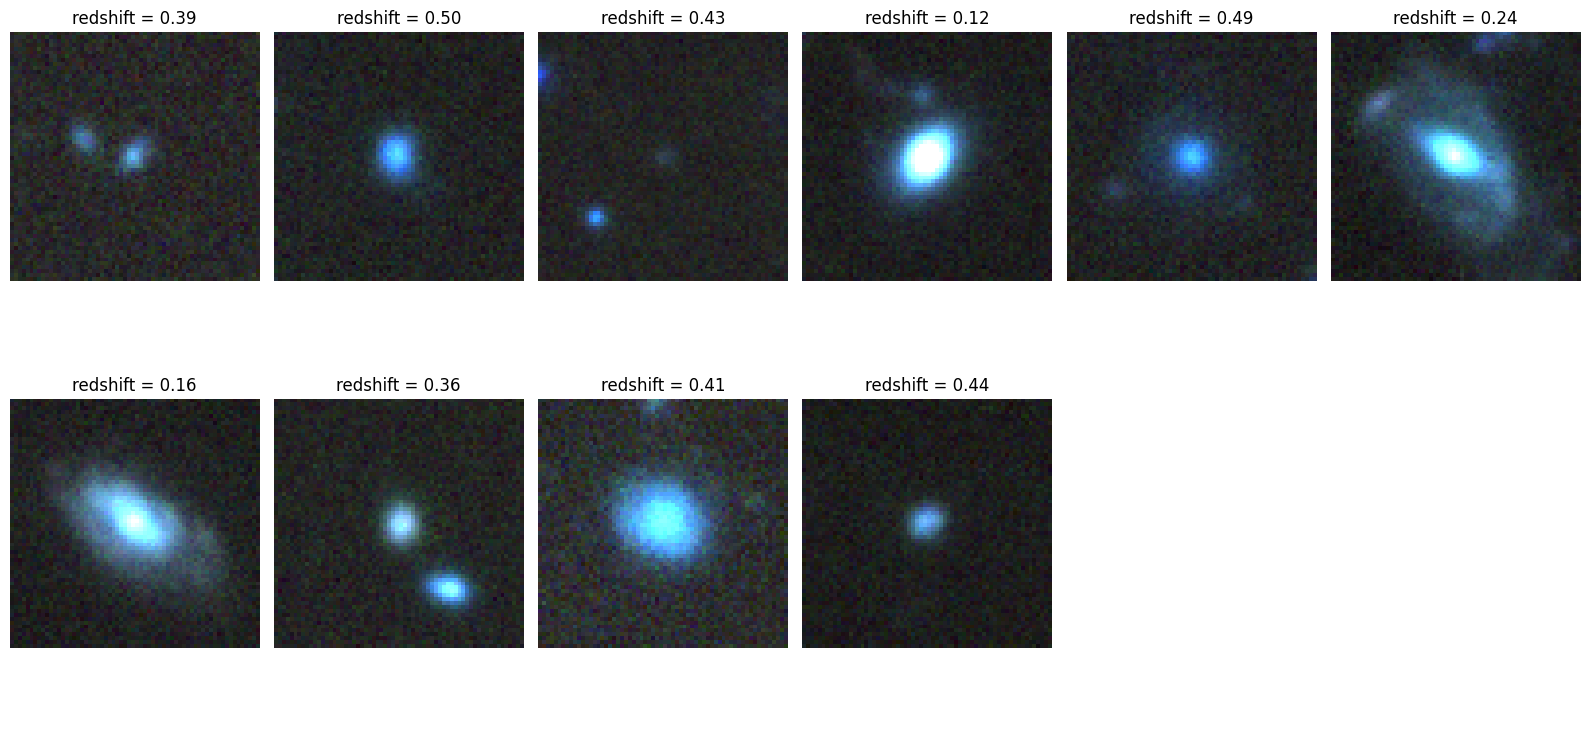


📊 Individual Channel View (g, r, i, z, y separately) - Generated Images:


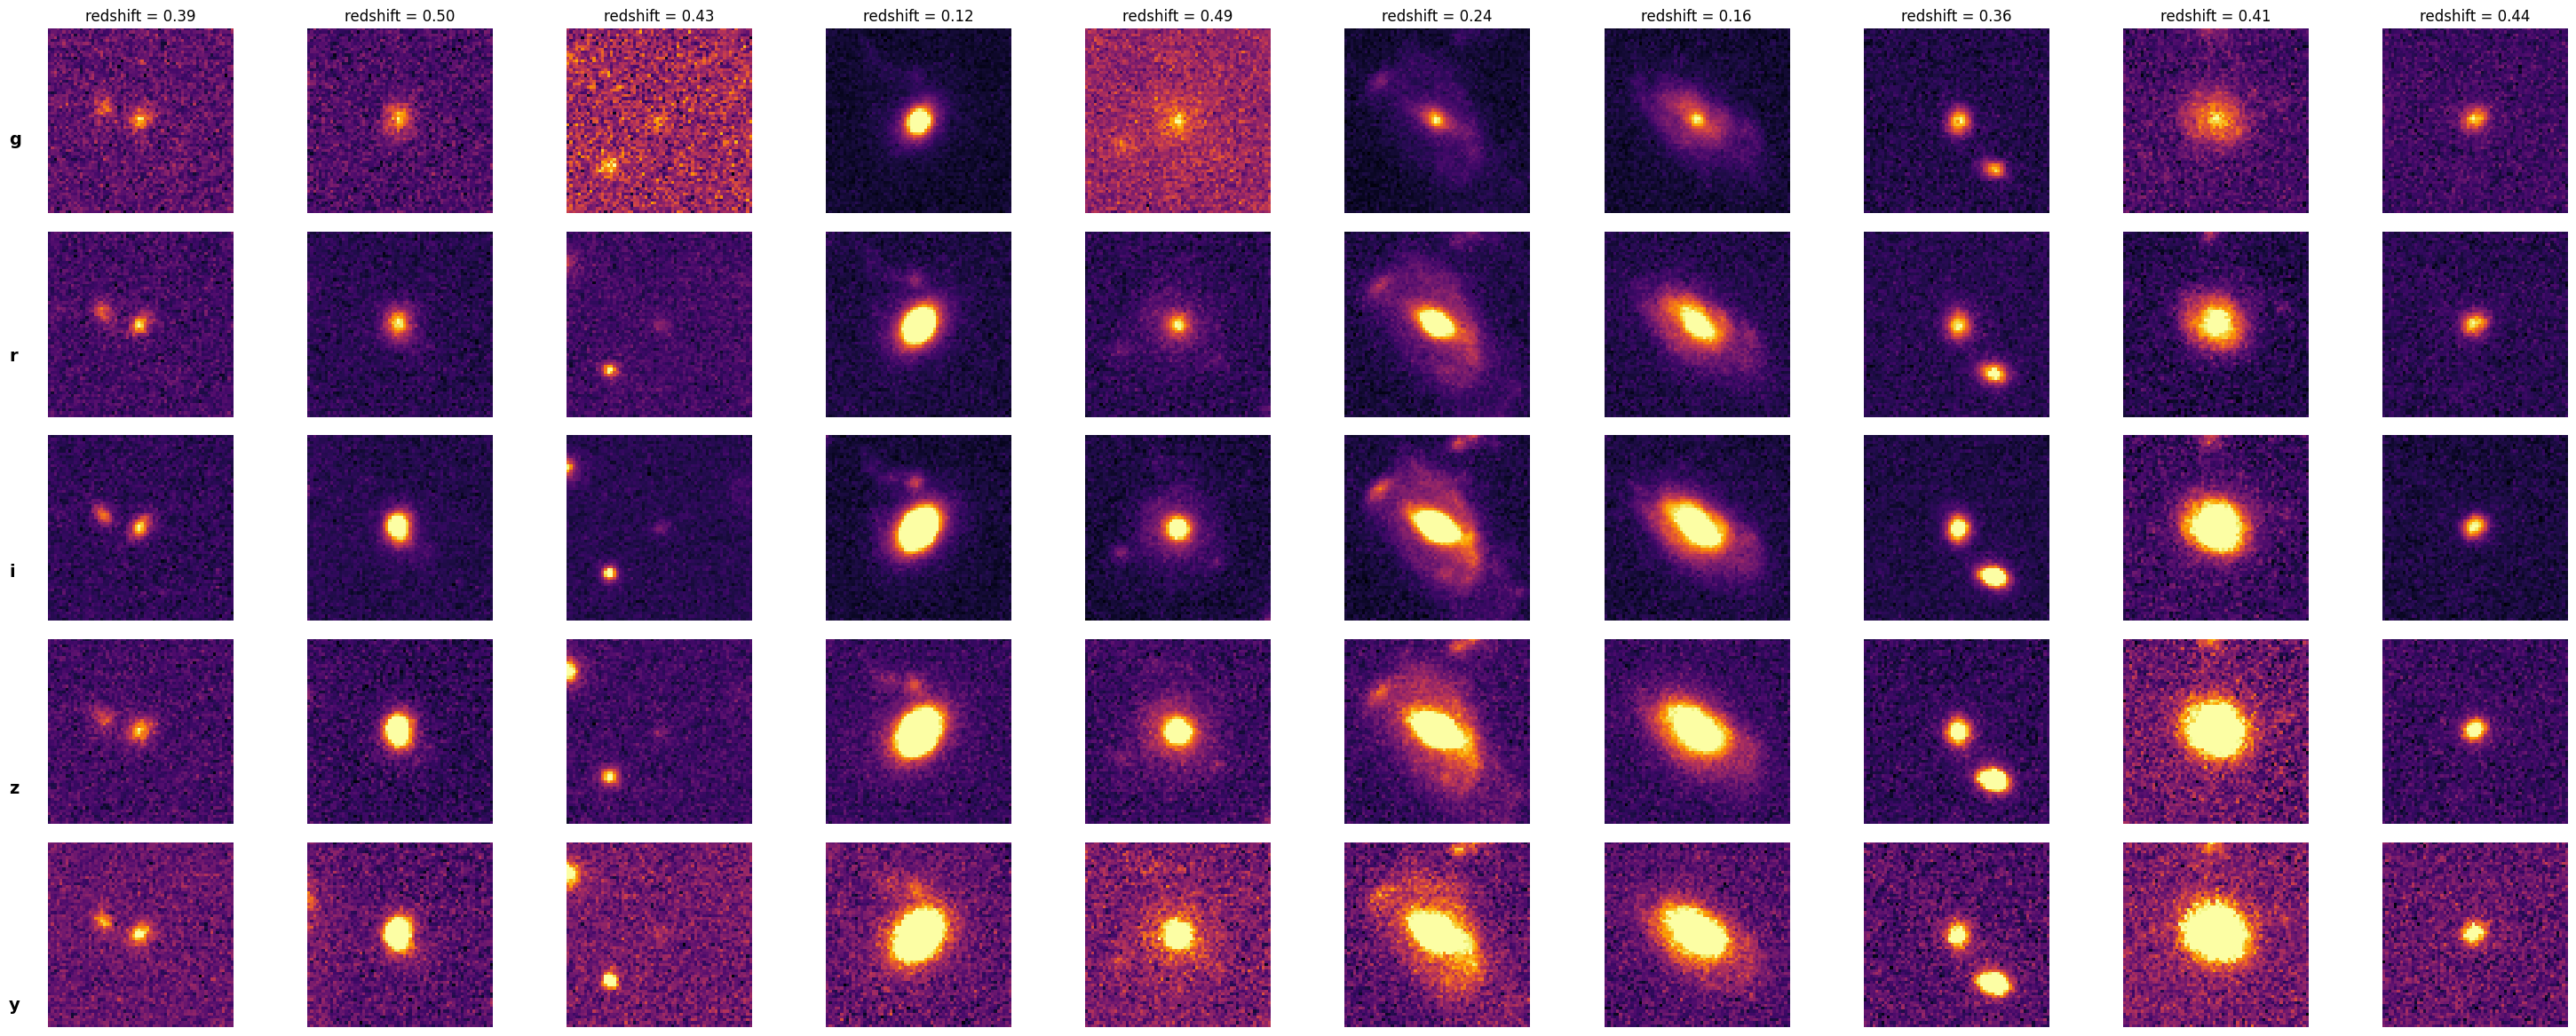


📊 Image Statistics - Generated Images:
Mean intensity: 0.5342
Standard deviation: 0.0903
Redshift range: 0.12 to 0.50

 Generation Settings:
  • Random Seed: 296123 (Random)
  • Redshift Distribution: Random
  • Redshift Range: 0.1 to 0.5

Display Settings:
  • Mode: Heatmap
  • Colormap: inferno

Quality Control:
  • Noise Filtering: Enabled
  • Filter Threshold: 0.25 (lower = stricter)

💡 Tip: Adjust these settings in the config section at the top of the notebook


In [15]:
print(f"Generated images shape: {generated_images.shape}")

# Prepare images for display
generated_images_denorm = denormalize_images(generated_images)
generated_images_denorm = torch.clamp(generated_images_denorm, 0.0, 1.0)

# Display RGB composite view
print("\n🎨 RGB Composite View (g, r, i channels combined) - Generated Images:")
plot_rgb_channels(
    images=generated_images_denorm,
    num_images=config['num_images'],
    max_std=config['max_std'],
    skip_filtering=config['skip_filtering'],
    redshifts=sample_redshifts   
)

# Display individual channel view
print("\n📊 Individual Channel View (g, r, i, z, y separately) - Generated Images:")
plot_all_channels(
    images=generated_images_denorm,
    num_images=config['num_images'],
    max_std=config['max_std'],
    cmap=config['cmap'],
    use_cmap=config['use_cmap'],
    skip_filtering=config['skip_filtering'],
    redshifts=sample_redshifts   
)

# Display statistics and settings
print("\n📊 Image Statistics - Generated Images:")
print(f"Mean intensity: {generated_images_denorm.mean().item():.4f}")
print(f"Standard deviation: {generated_images_denorm.std().item():.4f}")
print(f"Redshift range: {sample_redshifts.min().item():.2f} to {sample_redshifts.max().item():.2f}")

print("\n Generation Settings:")
print(f"  • Random Seed: {seed_to_use} ({'Fixed' if config['use_fixed_seed'] else 'Random'})")
print(f"  • Redshift Distribution: {'Random' if config['random_redshifts'] else 'Linear'}")
print(f"  • Redshift Range: {redshift_min} to {redshift_max}")

print("\nDisplay Settings:")
print(f"  • Mode: {'Heatmap' if config['use_cmap'] else 'Grayscale'}")
print(f"  • Colormap: {config['cmap'] if config['use_cmap'] else 'N/A'}")

print("\nQuality Control:")
print(f"  • Noise Filtering: {'Disabled' if config['skip_filtering'] else 'Enabled'}")
print(f"  • Filter Threshold: {config['max_std']} (lower = stricter)")

print("\n💡 Tip: Adjust these settings in the config section at the top of the notebook")

## 📊 Visualize Real Images For Comparison
*This reproduces the same approach we used above, but instead of displaying generated images it extracts real galaxy images from our testing dataset and displays them in the exact same way for easy visual comparison. You can easily edit the redshift range for the real imgaes by changing the valuse for redshift_min and redshift_max*

In [16]:
def load_real_images(hdf5_path, num_images, redshift_min=None, redshift_max=None, random_redshifts=True, seed_to_use=None):
    """
    Load real images from HDF5 file with optional redshift filtering.
    """
    # Generate a completely new random seed for this specific selection
    selection_seed = random.randint(0, 1000000)
    np.random.seed(selection_seed)
     
    
    with h5py.File(hdf5_path, 'r') as f:
        total_images = f['image'].shape[0]
        all_redshifts = f['specz_redshift'][:]
        
        # Filter by redshift range
        valid_indices = np.where((all_redshifts >= redshift_min) & 
                               (all_redshifts <= redshift_max))[0]
        
        if len(valid_indices) == 0:
            raise ValueError(f"No images found in redshift range {redshift_min} to {redshift_max}")
        
        # Select images
        if random_redshifts:
            print("Using random selection")
            selected_indices = np.random.permutation(valid_indices)[:num_images]
        else:
            print("Using linear spacing with random selection at each redshift")
            target_redshifts = np.linspace(redshift_min, redshift_max, num_images)
            selected_indices = []
            
            for target_z in target_redshifts:
                # Find all images near this redshift
                redshift_diffs = np.abs(all_redshifts[valid_indices] - target_z)
                # Get the indices of the 10 closest matches
                closest_matches = np.argsort(redshift_diffs)[:10]  # Take 10 closest matches
                # Randomly select one from these matches
                selected_idx = valid_indices[closest_matches[np.random.randint(0, len(closest_matches))]]
                selected_indices.append(selected_idx)
            
            selected_indices = np.array(selected_indices)
        
        # Sort indices for HDF5 access
        sorted_idx = np.argsort(selected_indices)
        sorted_selected_indices = selected_indices[sorted_idx]
        
        # Load images and redshifts
        selected_images = f['image'][sorted_selected_indices]
        selected_redshifts = f['specz_redshift'][sorted_selected_indices]
        
        # Restore original order
        selected_images = selected_images[np.argsort(sorted_idx)]
        selected_redshifts = selected_redshifts[np.argsort(sorted_idx)]
        
        # Reset random seed to original value if one was provided
        if seed_to_use is not None:
            np.random.seed(seed_to_use)
            
        return torch.tensor(selected_images), torch.tensor(selected_redshifts)


Loading real galaxies in redshift range: 0.1 to 0.5
Using random selection

🎨 RGB Composite View (g, r, i channels combined) - Real Images:


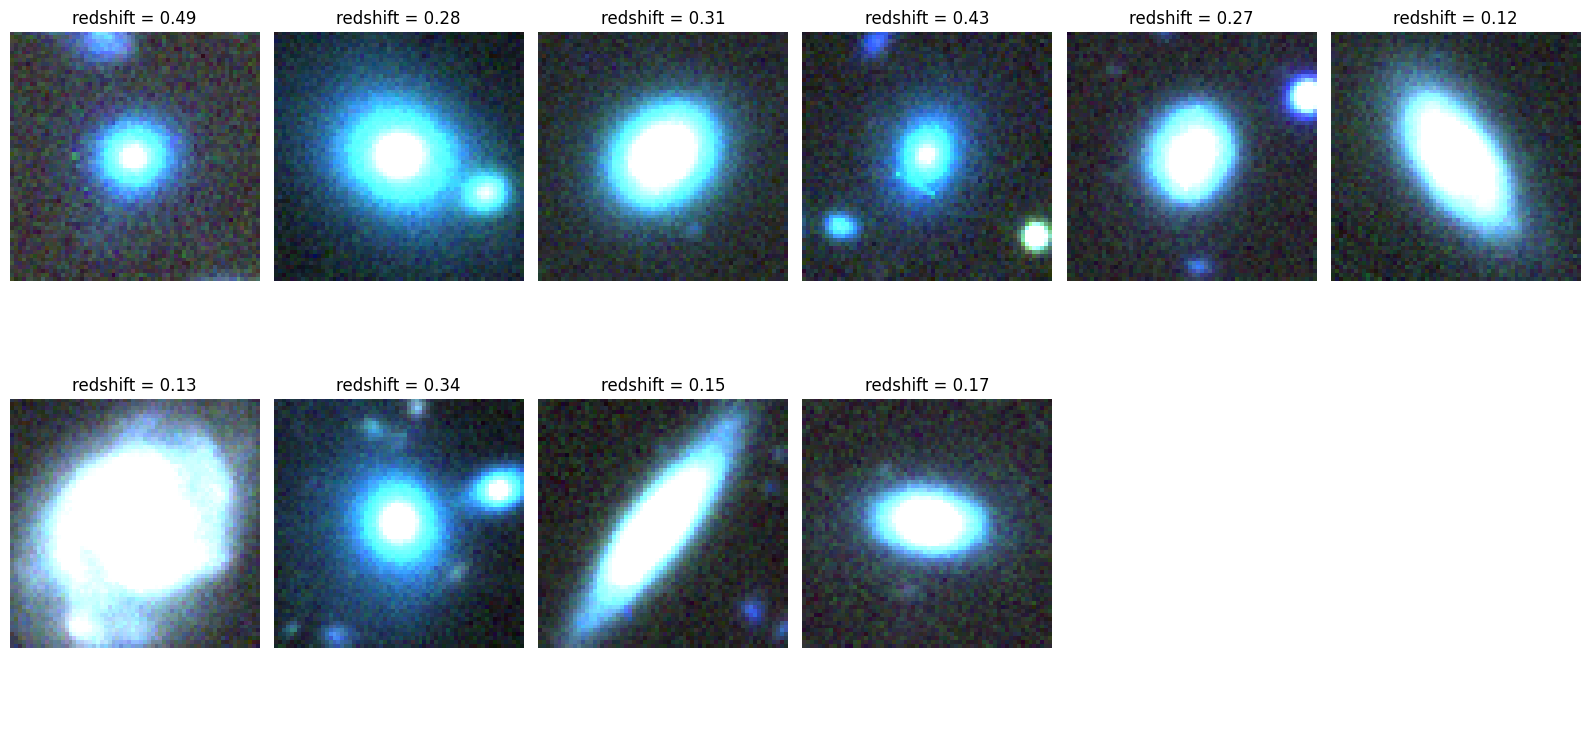


📊 Individual Channel View (g, r, i, z, y separately) - Real Images:


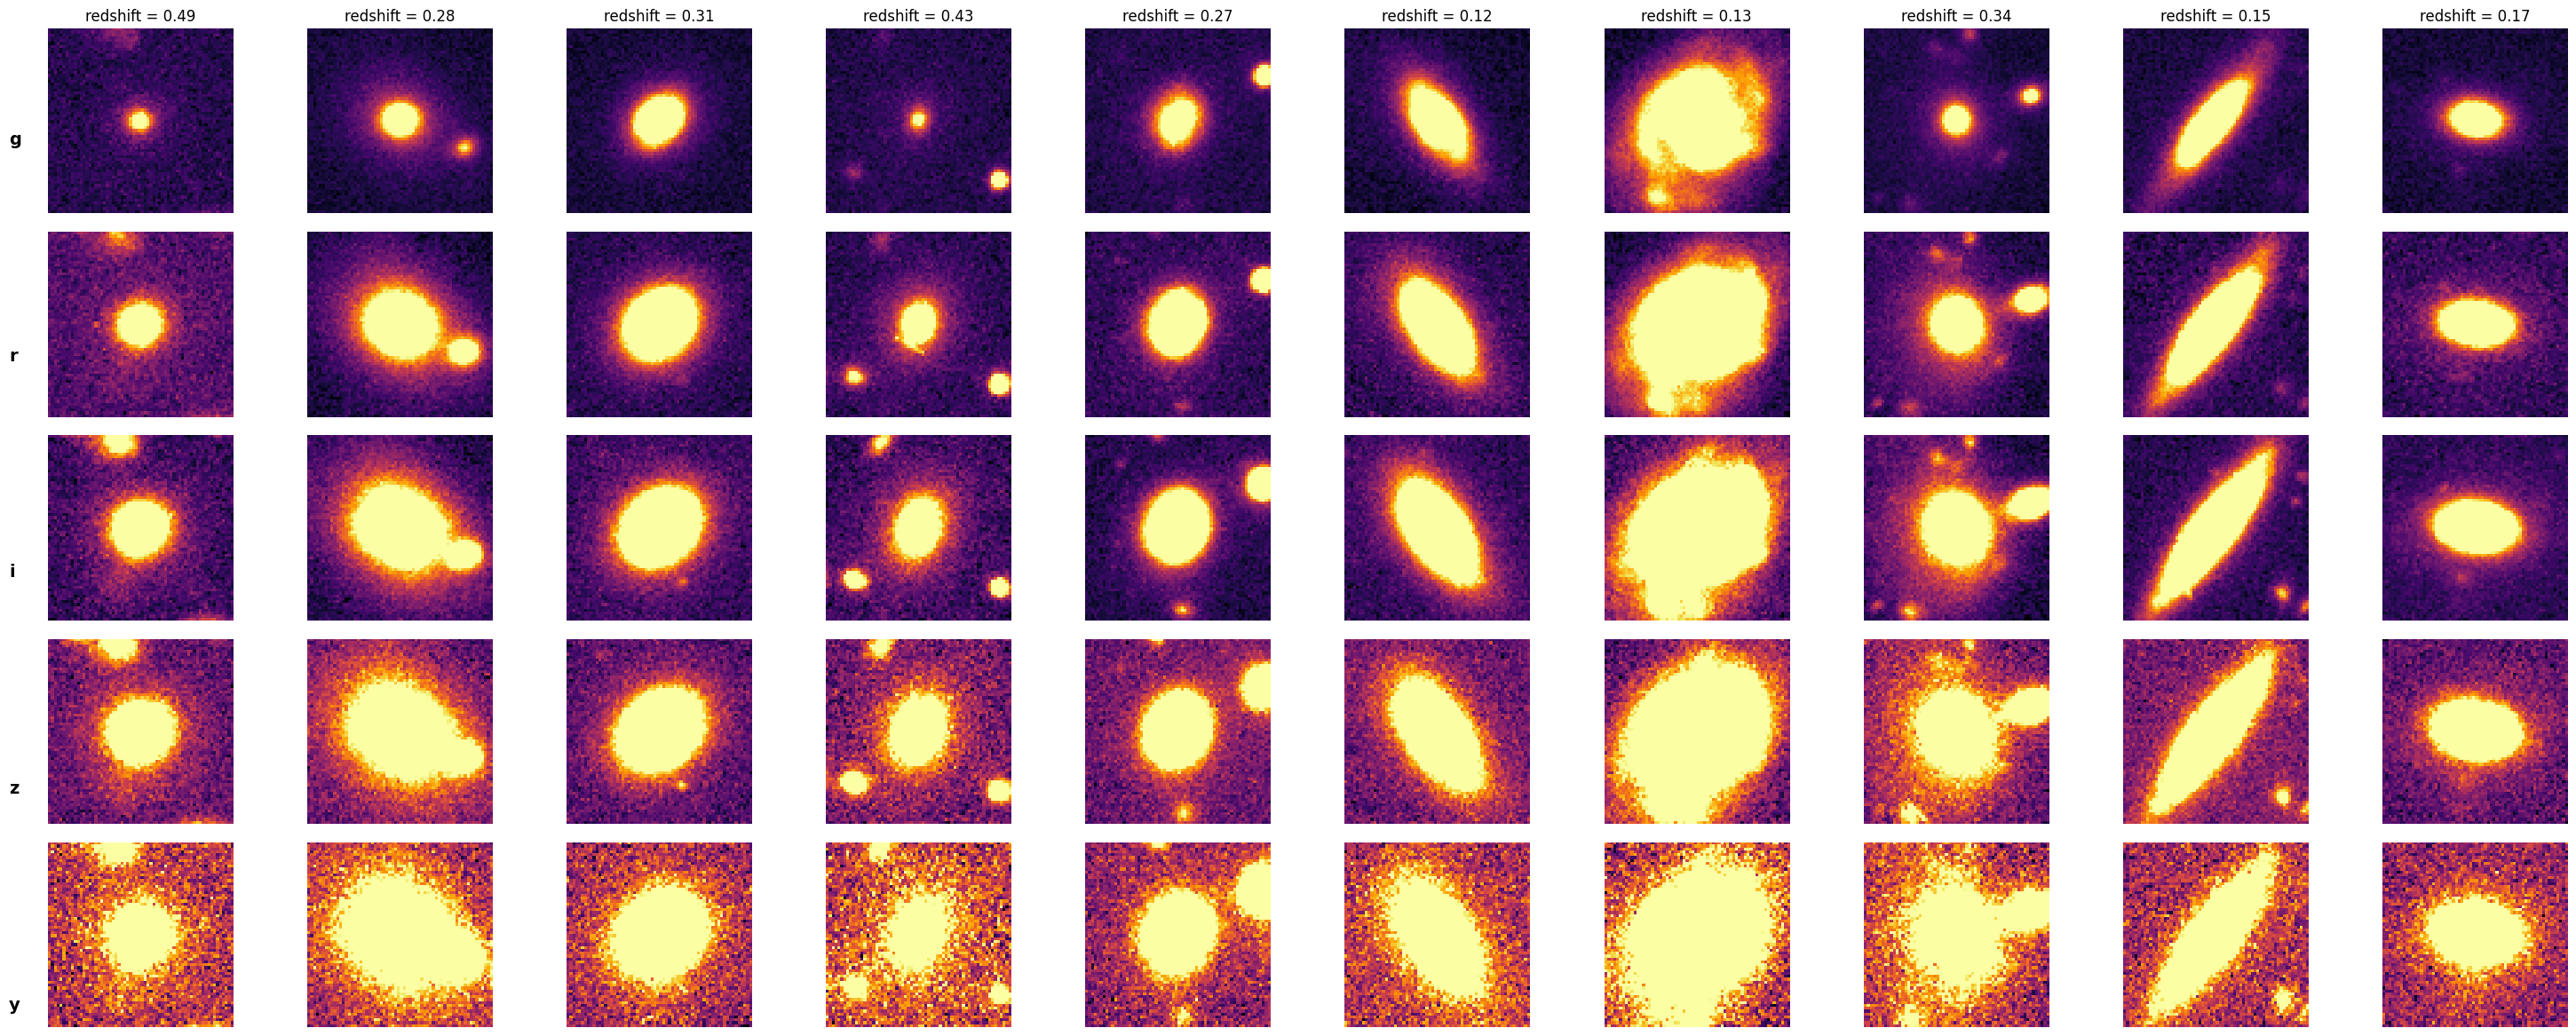


📊 Image Statistics - Real Images:
Mean intensity: 0.6681
Standard deviation: 0.1856
Redshift range: 0.12 to 0.49

 Current Settings for Real Images:
  • Redshift Distribution: Random
  • Redshift Range: 0.1 to 0.5

Display Settings:
  • Mode: Heatmap
  • Colormap: inferno

Quality Control:
  • Noise Filtering: Enabled
  • Filter Threshold: 0.25 (lower = stricter)


In [17]:
# Define the path to the testing HDF5 file
testing_hdf5_path = '/shared/astrodata/5x64x64_testing_with_morphology.hdf5'

# Define redshift range (similar to generated images)
redshift_min, redshift_max = 0.1, .5

print(f"\nLoading real galaxies in redshift range: {redshift_min} to {redshift_max}")

try:
    real_images_tensor, real_redshifts = load_real_images(
        testing_hdf5_path,
        config['num_images'],
        redshift_min=redshift_min,
        redshift_max=redshift_max,
        random_redshifts=config['random_redshifts'],
        seed_to_use=seed_to_use
    )
    
    # Normalize the real images for display
    real_images_denorm = denormalize_images(real_images_tensor)
    real_images_denorm = torch.clamp(real_images_denorm, 0.0, 1.0)

    # Display RGB composite view for real images
    print("\n🎨 RGB Composite View (g, r, i channels combined) - Real Images:")
    plot_rgb_channels(
        images=real_images_denorm,
        num_images=config['num_images'],
        max_std=config['max_std'],
        skip_filtering=config['skip_filtering'],
        redshifts=real_redshifts
    )

    # Display individual channel view for real images
    print("\n📊 Individual Channel View (g, r, i, z, y separately) - Real Images:")
    plot_all_channels(
        images=real_images_denorm,
        num_images=config['num_images'],
        max_std=config['max_std'],
        cmap=config['cmap'],
        use_cmap=config['use_cmap'],
        skip_filtering=config['skip_filtering'],
        redshifts=real_redshifts
    )

    # Display statistics and settings for real images
    print("\n📊 Image Statistics - Real Images:")
    print(f"Mean intensity: {real_images_denorm.mean().item():.4f}")
    print(f"Standard deviation: {real_images_denorm.std().item():.4f}")
    print(f"Redshift range: {real_redshifts.min().item():.2f} to {real_redshifts.max().item():.2f}")
    
    print("\n Current Settings for Real Images:")
    print(f"  • Redshift Distribution: {'Random' if config['random_redshifts'] else 'Linear'}")
    print(f"  • Redshift Range: {redshift_min} to {redshift_max}")
    print("\nDisplay Settings:")
    print(f"  • Mode: {'Heatmap' if config['use_cmap'] else 'Grayscale'}")
    print(f"  • Colormap: {config['cmap'] if config['use_cmap'] else 'N/A'}")
    print("\nQuality Control:")
    print(f"  • Noise Filtering: {'Disabled' if config['skip_filtering'] else 'Enabled'}")
    print(f"  • Filter Threshold: {config['max_std']} (lower = stricter)")
    
except ValueError as e:
    print(f"Error: {e}")
    print("Please try a different redshift range.")

# 🎯 Conclusion
*Congratulations! You've successfully generated artificial galaxies using a denoising diffusion probabilistic model.*

**Quick Tips:**
1. **Number and Type of Galaxies**
   - Adjust `num_images` in Essential Settings
   - Default: 10, can generate more or fewer as needed
   - Use `random_redshifts` to control redshift distribution

2. **Image Style**
   - Change `cmap` for different color schemes
   - Toggle `use_cmap` between heatmap and grayscale
   - Try 'magma' or 'viridis' for different visual insights

3. **Quality Control**
   - Lower `max_std` for stricter noise filtering
   - Set `skip_filtering` to True to see all images
   - Experiment with filtering settings gradually

4. **Reproducibility**
   - Enable `use_fixed_seed` for consistent results
   - Change `seed` value for different but reproducible patterns
   - Note that real galaxy selection remains random

*For best results, start with the default parameters and make small adjustments based on your needs.*

---

# 📚 Complete Parameter Reference
*A comprehensive guide to all available parameters in this notebook.*

## Essential Parameters
| Parameter | Default | Description |
|-----------|---------|-------------|
| `num_images` | 10 | Number of galaxies to generate |
| `use_cmap` | True | Toggle between heatmap and grayscale |
| `cmap` | 'inferno' | Colormap choice for visualization |
| `use_fixed_seed` | False | Enable for reproducible patterns |
| `seed` | None | Random seed when fixed seed is enabled |
| `random_redshifts` | False | Toggle between random and linear redshift spacing |

## Model Parameters
| Parameter | Default | Description |
|-----------|---------|-------------|
| `image_size` | 64 | Size of generated images |
| `noise_steps` | 1000 | Steps in diffusion process |
| `beta_start` | 1e-4 | Initial noise level |
| `beta_end` | 0.02 | Final noise level |
| `ema_decay` | 0.995 | Model stability parameter |

## Quality Control
| Parameter | Default | Description |
|-----------|---------|-------------|
| `max_std` | 0.25 | Noise filtering threshold |
| `skip_filtering` | False | Bypass noise filtering |

## Other Settings
| Parameter | Default | Description |
|-----------|---------|-------------|
| `redshift_range` | (0.10, 0.50) | Range of galaxy redshifts |
| `model_dir` | './Model_Checkpoints' | Directory for model files |
| `model_name` | 'best_model.pth' | Checkpoint filename |

**Colormap Options:**
- 'magma': Excellent for fine details
- 'inferno': Best contrast (recommended)
- 'viridis': Colorblind-friendly
- 'hot': Classic heatmap style
- 'gist_heat': Similar to afmhot

*Note: Most users will only need to adjust the Essential Parameters. Advanced parameters such as those found in the Model Parameters section should be modified with caution.*